Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.



## План:
1. Подготовка к анализу 
2. Анализ данных (EDA)
3. Построение модели прогнозирования оттока пользователей:
  - Разбивка на валидационную выборку;
  - Обучение модели на train-выборке;
  - Оценка метрик accuracy, precision и recall
   
4. Кластеризация пользователей:
  - Стандартизация данных;
  - Матрица расстояний;
  - Обучение модели кластеризации на основании алгоритма K-Means и прогноз кластеров клиентов;
  - Построим распределения признаков для кластеров;
  - Подсчет доли оттока
5. Вывод

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score


# 1. Подготовка данных к анализу 

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Все данные представлены в виде чисел, что облегчит задачу. В частности, существенноая часть данных представлена в виде булевых значений.

# 2. Анализ данных (EDA)

In [4]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [5]:
df['Churn'].value_counts()

0    2939
1    1061
Name: Churn, dtype: int64

Примем за факт, что ушедшие клиенты это 1, т.к. их меньше

In [6]:
churn = df.groupby('Churn').mean()
churn

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


По этим данным видно несколько любопытных деталей. Во-первых, те, кто уходят, в принципе не задерживаются в фитнес-клубе - у них короткие контракты, они посещают заведение менее месяца в среднем (Lifetime). А вот наличие привязки номера телефона роли никакой не играет. Интересен и возраст. Те, кто ушли, младше оставшихся клиентов. 

## Построим графики признаков. Для этого сначала разобъем данные на две части - с ушедшими клиентами и оставшимися


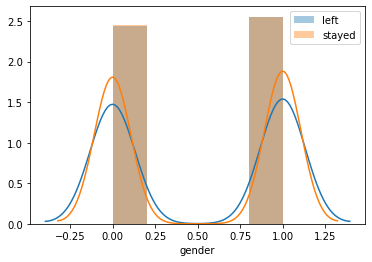

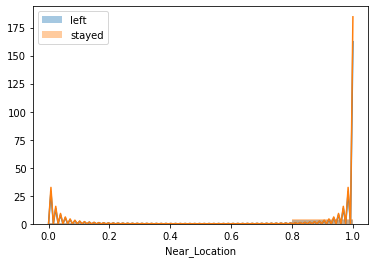

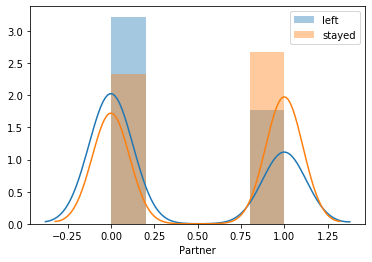

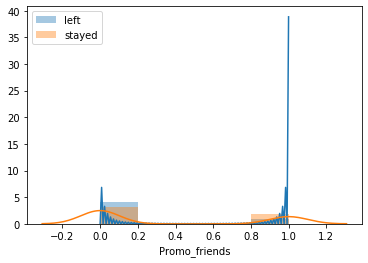

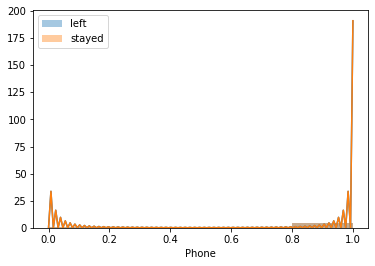

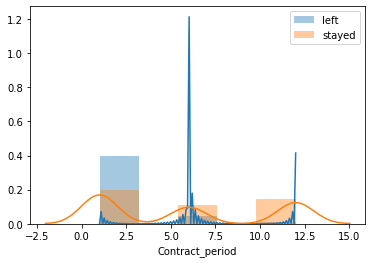

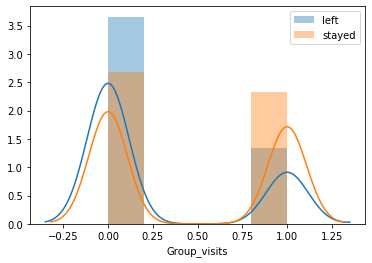

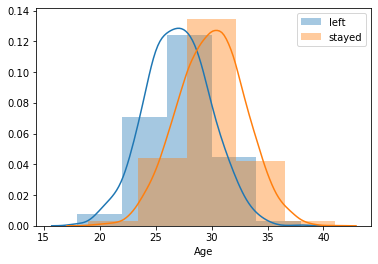

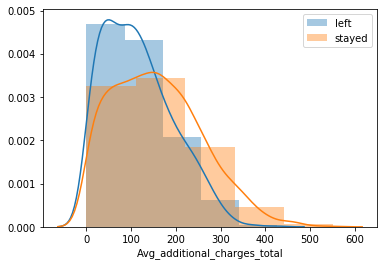

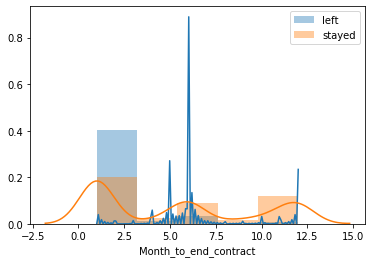

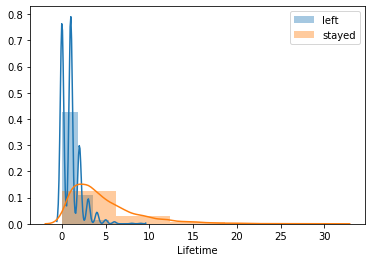

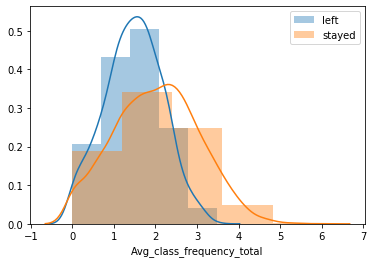

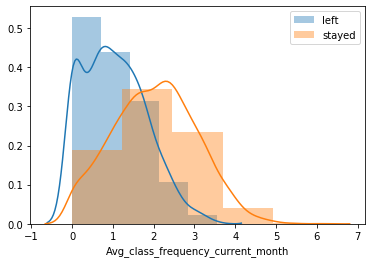

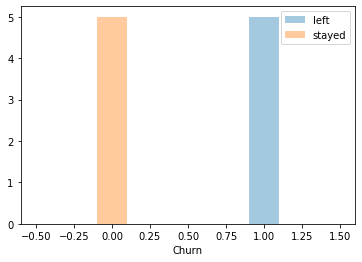

In [7]:
stayed = df.query('Churn == 0')
left = df.query('Churn == 1')
for feature in df.columns:
    sns.distplot(left[feature], label = 'left', bins = 5),
    sns.distplot(stayed[feature], label = 'stayed', bins = 5)
    plt.legend()
    plt.show()



По этим графикам уже можно сделать некоторые выводы. Например, люди, у которых были длительные контракты реже покидают фитнесс-клуб. Те же, кто уходит контракты заключили не так давно.Сотрудники компаний-партнеров так же реже покидают, чем просто клиенты. Хотя эта метрика как раз таки может быть не связана напрямую с фитнес-клубом, а с основным местом работы. Те, кто ходят на групповые занятия реже покидают, чем те, кто не ходят. Но групповые занятия в целом менее популярны индивидуальных тренировок. Ушедшие клиенты практически не тратили деньги в фитнес-клубе, в отличие от освтавшихся клиентов. 

Вообще, все ушедшие клиенты не очень часто посещали фитнес-клуб,покупали абонимент на короткий срок, посещали клуб около месяца. То есть скорее всего, это были неосознанные клиенты и/или те, кому не что-то не понравилось в фитнес-клубе




## Построим матрицу корреляций

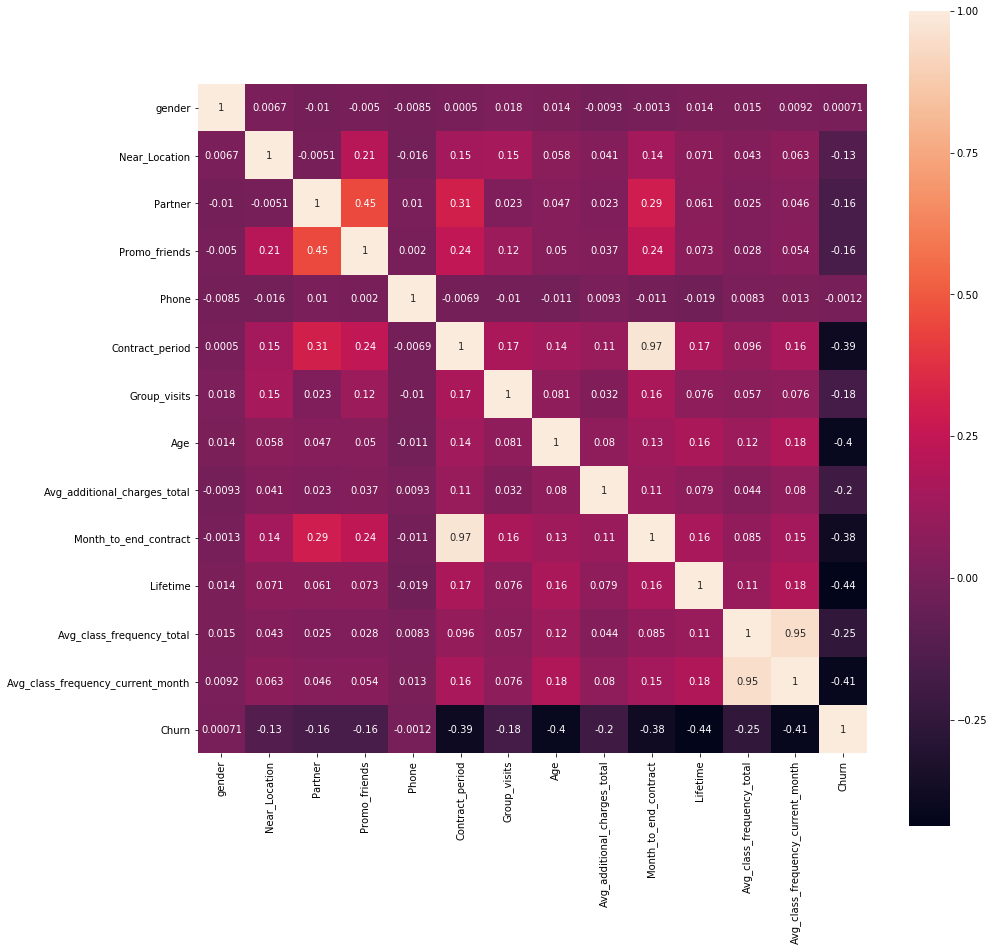

In [8]:
cd = df.corr()
plt.figure(figsize = (15, 15))
sns.heatmap(cd, annot = True, square = True)

plt.show()

Интересно, что есть корреляция между клиентами из компаний-партнеров и тех, кто пришел по акции "приведи друга". Переменная "Churn" не коррелирует ни с одной из других переменных. Также интересно, что клиенты из компаний партнеров имеют длительные абонименты и, соотвественно, долго оставются клиентами фитнес-клуба.

# 3. Построение модели прогнозирования оттока пользователей

## Разобьем данные на обучающую и валидационную выборку

In [9]:
y = df['Churn']
X = df.drop('Churn', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  stratify = y, random_state = 0)

## Обучение модели на train-выборке

Сначала обучим модель логистической регрессии:

In [10]:
model = LogisticRegression(random_state = 0)
model.fit(X_train, y_train)
pred = model.predict(X_test)

Теперь модели случайного леса:

In [11]:
model1 = RandomForestClassifier(random_state = 0)
model1.fit(X_train, y_train)
pred1 = model1.predict(X_test)

## Оценка метрик accuracy, precision и recall

In [12]:
print('Оценки метрик для модели логистической регрессии')
print('Accuracy for logic: {:.2f}'.format(accuracy_score(y_test, pred)))
print('Precision for logic: {:.2f}'.format(precision_score(y_test, pred)))
print('Recall for logic: {:.2f}'.format(recall_score(y_test, pred)))

Оценки метрик для модели логистической регрессии
Accuracy for logic: 0.93
Precision for logic: 0.89
Recall for logic: 0.84


In [13]:
print('Оценки метрик для модели случайного леса')
print('Accuracy for forest: {:.2f}'.format(accuracy_score(y_test, pred1)))
print('Precision for forest: {:.2f}'.format(precision_score(y_test, pred1)))
print('Recall for forest: {:.2f}'.format(recall_score(y_test, pred1)))

Оценки метрик для модели случайного леса
Accuracy for forest: 0.92
Precision for forest: 0.89
Recall for forest: 0.79


Логистическая регрессия выглядит лучше, чем модель случайного леса

# Кластеризация пользователей

## Стандартизация данных

In [14]:
scaler = StandardScaler()


X_sc = scaler.fit_transform(X)

## Матрица расстояний

In [15]:
linked = linkage(X_sc, method = 'ward')

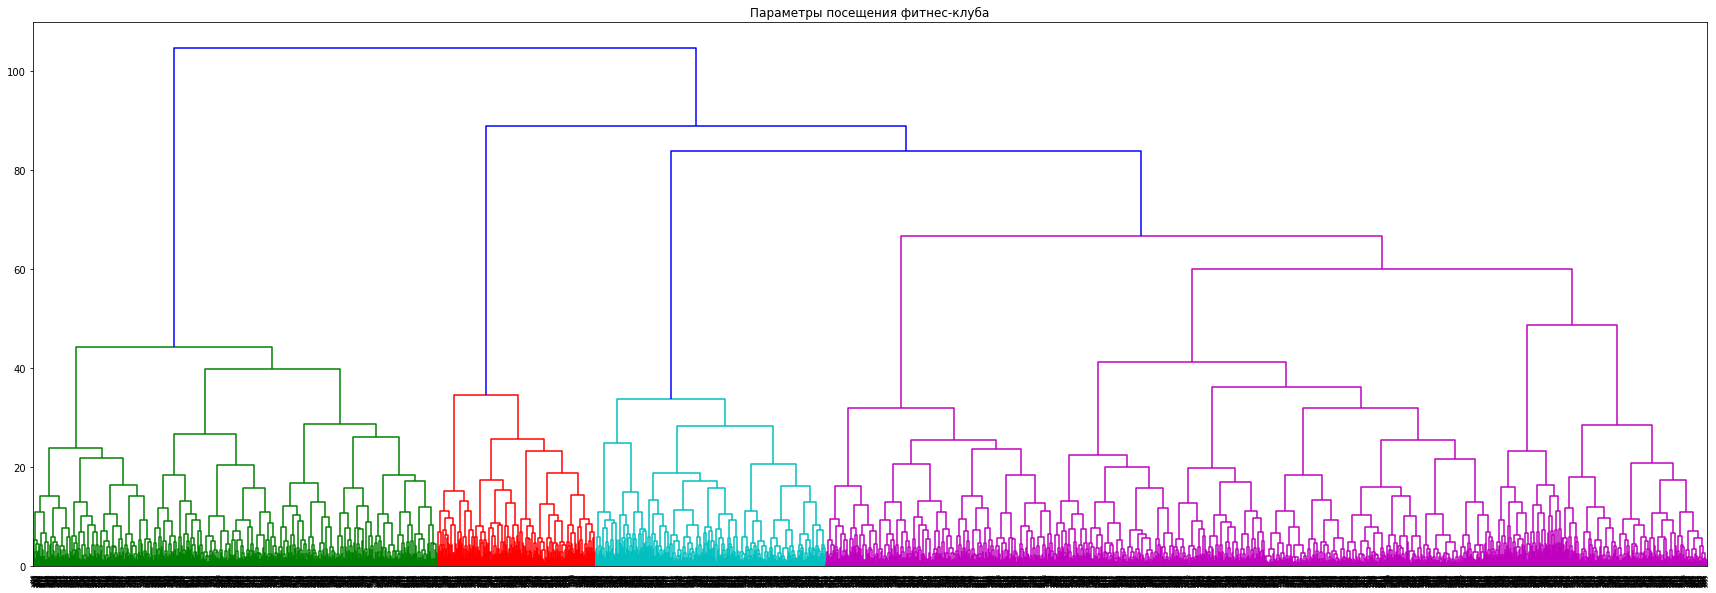

In [16]:
plt.figure(figsize=(30, 10))  
dendrogram(linked, orientation='top')
plt.title('Параметры посещения фитнес-клуба')
plt.show()

Мы видим тут 4 разных кластеров. Их и выделим

## Обучение модели кластеризации на основании алгоритма K-Means и прогноз кластеров клиентов

In [17]:
km = KMeans(n_clusters = 5)
clust = km.fit_predict(X_sc)

Посмотрим на качество кластеризации:

In [18]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, clust)))

Silhouette_score: 0.14


Не самый выдающийся результат, но все-таки неплохой

Посмотрим на средние занчения для кластеров:

In [19]:
df['clusters'] = clust
mean = df.groupby('clusters').mean()
mean

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
clusters,,,,,,,,,,,,,,
0,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
1,0.484921,1.000000,0.351587,0.239683,1.000000,1.953968,0.339683,28.167460,131.776484,1.861905,2.430159,1.246780,1.011828,0.515079
2,0.503469,0.959366,0.782953,0.574827,1.000000,10.893954,0.543112,29.986125,160.821737,9.958375,4.736373,1.981969,1.974655,0.027750
3,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
4,0.560048,0.976219,0.355529,0.230678,0.998811,2.663496,0.475624,30.116528,161.281415,2.454221,4.908442,2.848533,2.846643,0.067776


3(2) и 5(4) кластеры выделяются в лучшую сторону, т.е. это кластеры, где клиенты в основном остаются. Что интересно, возраст клиентов в этих кластерах около 30 - 30 лет

## Построим распределения признаков для кластеров

In [29]:
df_1 = df.drop(['Age', 'Avg_additional_charges_total', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month'], axis = 1)

In [30]:
df_2 = df.drop(['Month_to_end_contract', 'Group_visits', 'Contract_period', 'Phone', 'Promo_friends', 'Partner', 'Churn', 'Near_Location', 'gender'], axis = 1)

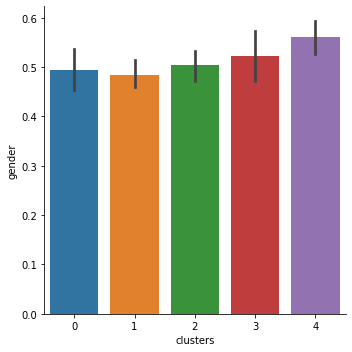

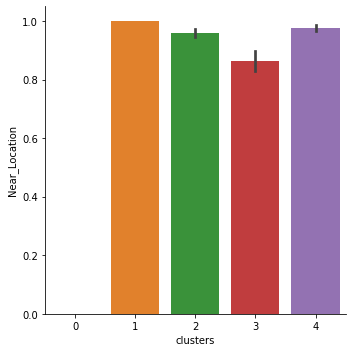

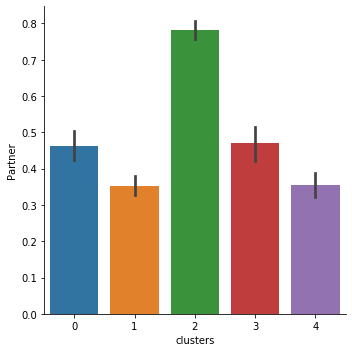

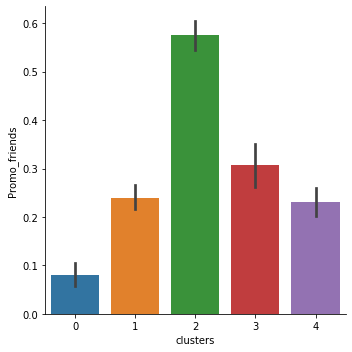

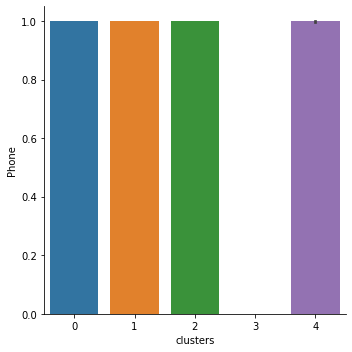

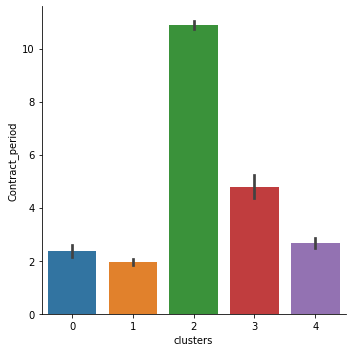

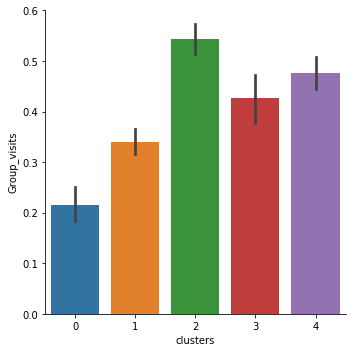

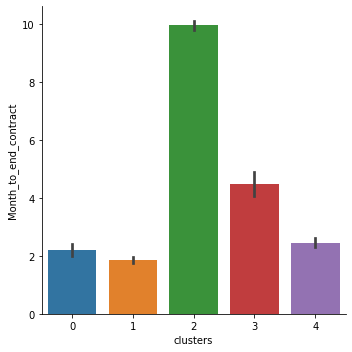

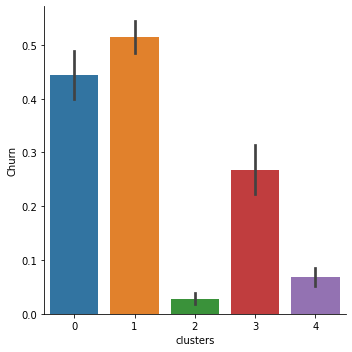

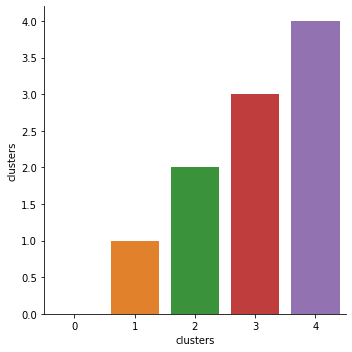

In [31]:
for column in df_1:
    sns.catplot(x= 'clusters', y= column, data=df_1, kind = 'bar')
    plt.show()

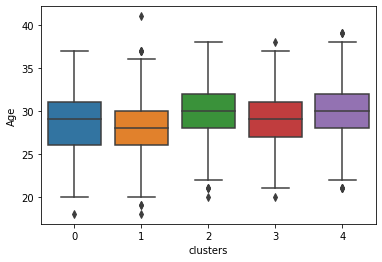

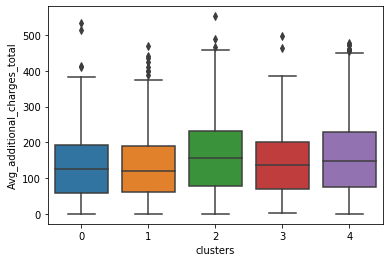

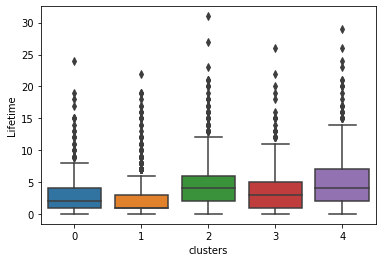

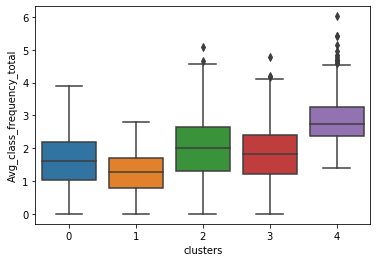

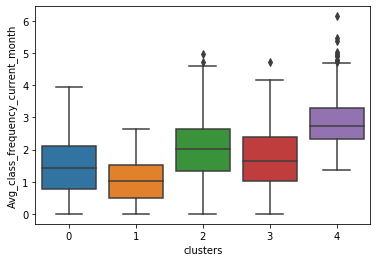

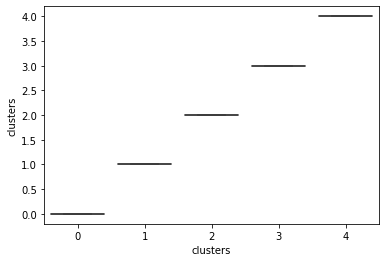

In [32]:
for column in df_2:
    sns.boxplot(x= 'clusters', y= column, data=df_2)
    plt.show()

<div class="alert alert-danger">
<h3> Комментарий от ревьювера</h3>

Для непрерывных переменных лучше использовать boxplot :)
    
</div>

<span style="color:blue">Мне кажется, что boxplot не очень смотрится, мало что понятно<span>

<div class="alert alert-danger">
<h3> Комментарий от ревьювера v2</h3>

Я посоветовала его для **непрерывных** переменных, для логических и дискретных графики были хорошие. По боксплотам можно оценить средние, выбросы и т.д. Это удобно для сравнения. Если они тебе совсем не нравятся, можно построить гистограммы.
    
</div>

<span style="color:blue">Я тогда просто в двух разных переменных сделал<span>

Третий кластер(2) имеет больше всего клиентов из компаний-партнеров и, соответственно, больше клиентов приведенных по программе "Пригласи друга". Это соответсвует корреляционной матрице, которую мы строили ранее. Самые длительные контракты тоже у третьего кластера (2). А вот чаще всего фитнес-клуб посещают клиенты из второго кластера (1).
В целом же мы видим, что у 1(0) и 2(1) кластера самые низкие показатели по длительности контрактов, частоте посещений, покупке дополнительных услуг в фитнес-клубе.

## Подсчет доли оттока

In [33]:
df['count'] = 1


In [34]:
leavers = df.query('Churn == 1')
leavers = leavers.groupby('clusters').agg({'count':'sum'}).reset_index()

In [35]:
overall = df.groupby('clusters').agg({'count':'sum'}).reset_index()
left_percent = overall.merge(leavers, on = 'clusters')
left_percent

,clusters,count_x,count_y
0,0,505,224
1,1,1260,649
2,2,1009,28
3,3,385,103
4,4,841,57


In [36]:
left_percent['left%'] = left_percent['count_y'] / left_percent['count_x'] * 100
left_percent['left%'] = left_percent['left%'].apply(np.ceil)
left_percent

,clusters,count_x,count_y,left%
0,0,505,224,45.0
1,1,1260,649,52.0
2,2,1009,28,3.0
3,3,385,103,27.0
4,4,841,57,7.0


1(0) и 2(1) кластеры имеют наибольший процент оттока. 

# 5. Вывод

Чаще всего в фитнес-клуб перестают ходить те, кому скорее всего не понравилось. Потому что в основном отток идет среди тех клиентов, у которых краткосрочные абонементы, которые не очень часто посещают заведение, которые не склонные тратить деньги на какие-то дополнительные услуги. Да и вообще всех этих клиентов объединяет очень небольшой период посещения фитнес-клуба. Возможно, стоит ввести специальное предложение. Напрмиер, первые 2-3 посещения бесплтано.Это гарантировано вызовет приток новых клиентов.

Еще один вариант - продавать выгодные пакеты абонементов, где, допустим будет посещение + еще что-то(бассейн, сауна, бокс, аэробика). 

Также можно сделать групповые занятия более привлекательными. Согласно данным те, кто не ходит на групповые занятия, скорее всего фитнес-клуб в итоге покинут. Поэтому надо продумать возможность расширения групп и/или других предложений, которые бы способствовали социализации клиентов в фитнес-клубе

<div style="border:solid black 2px; padding: 20px">
<h3>Чек-лист доработок</h3>

По проекту видно, что ты достаточно уверенно кодишь и корректно используешь все инструменты. Мне было очень приятно проверять твою работу! Она уже 🔥, но мы ее сделаем прям 🔥🔥🔥

Прошу тебя проработать следующие моменты:

1. **Добавить комментарии.**
2. **Подкорректировать этап кластеризации.**

Жду твой проект на повторное ревью, осталось совсем чуть-чуть. Не стесняйся оставлять комментарии и задавать вопросы. Удачи! Все получится 🙂

</div>

<div style="border:solid black 2px; padding: 20px">
<h3>Чек-лист доработок  v2</h3>

Нужно проработать два нюанса:

1. **Подкорректировать этап кластеризации.**
2. **Заменить часть графиков на старые в кластеризации.**

Жду твой проект на повторное ревью, ты уже на финише 🙂

</div>